In [2]:
import itertools
import numpy as np
import numpy.random as npr
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import colors
from matplotlib import gridspec
import matplotlib

import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D  

import scipy.io
from scipy.io import loadmat
from scipy.io import savemat
from scipy import stats
from scipy.special import softmax
from sklearn.metrics import log_loss
import pickle
import copy

%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.family':'Arial'})

## Read Data

In [16]:
subjectNames = ['sam','tabitha','chloe','blanche','b01','b02','b03','b04','b05','b06','b07','b08','b09','b10']

numSubjects = len(subjectNames)

stateNames = ['Persist','Preferred','Random','Avoid']
historyNames = ['(0,0)','(1,0)','(0,1)','(1,1)']

speciesList = np.array([0,0,0,0,1,1,1,1,1,2,2,2,2,2])

speciesColor = ['#fb8072','#8dd3c7','#74add1']
speciesDColor = ['#6a0e03','#1d4c44','#183649']
speciesNames = ['monkey','human','human2']
speciesNameLeg = ['Monkeys','Human DS1', 'Human DS2']


def getPM(N):
    if N == 1:
        return 1
    elif N > 1:
        x = np.zeros([N])
        x[0] = 1
        for i in np.arange(1,N):
            x[i] = -1 * x[i-1]
        return x

######################################

analysis = []
data = []
data0 = []


for i in range(numSubjects):
    with open('analysis/'+subjectNames[i]+'.pickle', 'rb') as f:
        [A] = pickle.load(f)
    analysis.append(A)
    with open('data/'+subjectNames[i]+'.pickle', 'rb') as f:
        [D] = pickle.load(f)
    data.append(D)
    data0.append(D)
    
subjectNames = ['1','2','3','4','1','2','3','4','5','1','2','3','4','5']


categoryNames = ['Perseveration',
                 'Random search',
                 'Non-rule \n exploration',
                 'Rule favored, \n exploration',
                 'Rule preferred',
                 'Rule exploitation']

### Collect Data

In [4]:
proportionExplore = np.zeros([numSubjects])
uniqueExplore = []
simultaneousExplore = []
ellNonRuleExplore = []

for i in range(numSubjects):
    proportionExplore[i] = analysis[i]['categoryAnalysis']['exploreTrialsProportion']
    uniqueExplore.append(analysis[i]['categoryAnalysis']['numNonRuleExplore'])

    X = np.concatenate(analysis[i]['categoryAnalysis']['simultaneousExplore'])
    X = X[X>0]
    simultaneousExplore.append(X)

    X = analysis[i]['categoryAnalysis']['ellAllExplore']
    Y = []
    for j in range(len(X)):
        Y.append(np.concatenate(X[j]))
    ellNonRuleExplore.append(np.concatenate(Y))

## Percent trials with explored feature(s)

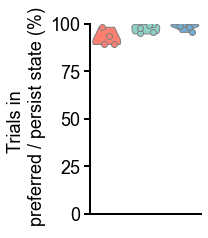

In [14]:
# Plot
fig, ax = plt.subplots(figsize=(2,3.5))

vpWidth = 0.5

for spInd in range(3): # Species
    idx = np.where(np.array(speciesList) == spInd)[0]
    dat = proportionExplore[idx]*100.0
    
    # Violins
    vp = ax.violinplot(dat,[spInd*0.7],showextrema=False,widths=vpWidth)
    for pc in vp['bodies']:
        pc.set_facecolor(speciesColor[spInd])
        pc.set_edgecolor('gray')
        pc.set_alpha(1)

    # Points
    x = npr.rand(idx.shape[0]) * (vpWidth) * (0.3)
    pm = getPM(idx.shape[0])
    x = np.multiply(x,pm) + spInd*0.7
    
    ax.scatter(x,dat,color=speciesColor[spInd],edgecolors='gray')        
    ax.scatter(i*0.7,np.mean(dat),color='white',s=50,edgecolors='gray')

# Prettify
ax.set_ylim([0,100])
ax.set_xlim([-0.3,1.7])
ax.set_xticks([])
ax.set_yticks([0,25,50,75,100])
ax.set_ylabel('Trials in \n preferred / persist state (%)',fontsize=18)
ax.tick_params(axis='x',labelsize= 18,direction='out',length=6,width=2)
ax.tick_params(axis='y',labelsize= 18,direction='out',length=6,width=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

# plt.savefig('figures/fig4/trialsInExp.eps', format='eps')

## No. of explored features per rule block

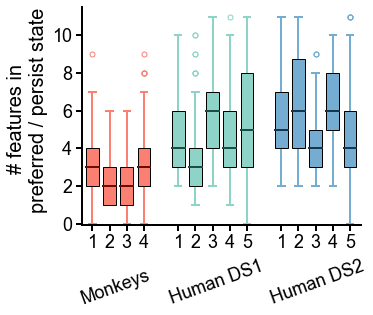

In [27]:
fig, ax = plt.subplots(figsize=(5,4))

xPos = []

pos = -0.8*2
for spInd in range(3): # Species
    idx = np.where(np.array(speciesList) == spInd)[0]

    # Setup boxplot params
    prop1 = dict(color=speciesColor[spInd],linewidth=2)
    prop2 = dict(color=speciesDColor[spInd],linewidth=2)
    prop3 = dict(markeredgecolor=speciesColor[spInd],marker='.',markersize=10,linewidth=4)

    pos += 0.8
    for i in idx: # individuals in species

        pos += 0.8

        xPos.append(pos)

        bp = ax.boxplot(uniqueExplore[i],positions=[pos],widths=0.6,patch_artist=True,medianprops=prop2,whiskerprops=prop1,capprops=prop1,flierprops=prop3,zorder=0)

        bp['boxes'][0].set_facecolor(speciesColor[spInd])

    fig.text(0.22+0.28*spInd, -0.15, speciesNameLeg[spInd], ha='center', size=18,rotation=20)

        
# Prettify
ax.set_xlim([xPos[0]-0.5,xPos[-1]+0.5])
ax.set_ylim([-0.05,11.5])
ax.set_xticks(xPos)
ax.set_xticklabels(subjectNames,fontsize=10)

ax.set_ylabel('# features in \n  preferred / persist state',fontsize=20)

ax.tick_params(axis='both',direction='out',width=2, length=6)
ax.tick_params(axis='x',labelsize=18)
ax.tick_params(axis='y',labelsize=18)
# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_axisbelow(True)

# plt.savefig('figures/fig4/featExpPerBlock.eps', format='eps')

## No. of simultaneously explored features

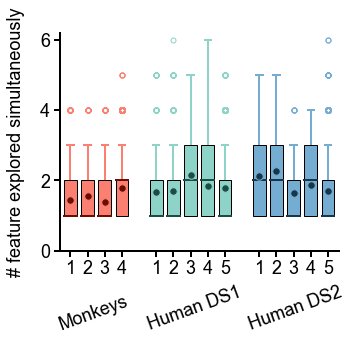

In [32]:
fig, ax = plt.subplots(figsize=(5,4))

xPos = []

pos = -0.8*2
for spInd in range(3): # Species
    idx = np.where(np.array(speciesList) == spInd)[0]

    # Setup boxplot params
    prop1 = dict(color=speciesColor[spInd],linewidth=2)
    prop2 = dict(color=speciesDColor[spInd],linewidth=2)
    prop3 = dict(markeredgecolor=speciesColor[spInd],marker='.',markersize=10,linewidth=4)
    prop4 = dict(markerfacecolor=speciesDColor[spInd],
                 markeredgecolor=speciesColor[spInd],marker='.',markersize=15)

    pos += 0.8
    for i in idx: # Individuals

        pos += 0.8

        xPos.append(pos)
        bp = ax.boxplot(simultaneousExplore[i],positions=[pos],widths=0.6,patch_artist=True,medianprops=prop2,whiskerprops=prop1,
                        capprops=prop1,flierprops=prop3,zorder=0,showmeans=True,meanprops=prop4)

        bp['boxes'][0].set_facecolor(speciesColor[speciesList[i]])

    fig.text(0.22+0.28*spInd, -0.15, speciesNameLeg[spInd], ha='center', size=18,rotation=20)

# Prettify
ax.set_xlim([xPos[0]-0.5,xPos[-1]+0.5])
ax.set_ylim([0,6.2])
ax.set_xticks(xPos)
ax.set_xticklabels(subjectNames,fontsize=10) #rotation=30,

ax.set_ylabel('# feature explored simultaneously',fontsize=18,labelpad=15)

ax.tick_params(axis='both',direction='out',width=2, length=6)
ax.tick_params(axis='x',labelsize=18)
ax.tick_params(axis='y',labelsize=18)
# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_axisbelow(True)

# plt.savefig('figures/fig4/featExpSimult.eps', format='eps')

## No. continuous trials spent exploring a feature

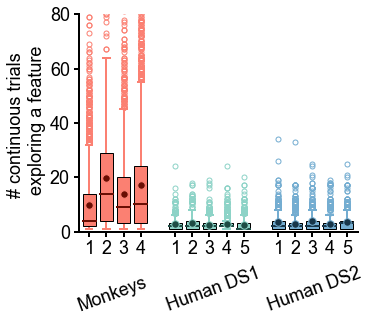

In [35]:
fig, ax = plt.subplots(figsize=(5,4))

xPos = []


pos = -0.8*2
for spInd in range(3): # Species
    idx = np.where(np.array(speciesList) == spInd)[0]

    # Setup boxplot params
    prop1 = dict(color=speciesColor[spInd],linewidth=2)
    prop2 = dict(color=speciesDColor[spInd],linewidth=2)
    prop3 = dict(markeredgecolor=speciesColor[spInd],marker='.',markersize=10,linewidth=4)
    prop4 = dict(markerfacecolor=speciesDColor[spInd],
                 markeredgecolor=speciesColor[spInd],marker='.',markersize=15)

    pos += 0.8
    for i in idx: # individuals

        pos += 0.8

        xPos.append(pos)
        bp = ax.boxplot(ellNonRuleExplore[i],positions=[pos],widths=0.6,patch_artist=True,medianprops=prop2,whiskerprops=prop1,
                        capprops=prop1,flierprops=prop3,zorder=0,showmeans=True,meanprops=prop4)

        bp['boxes'][0].set_facecolor(speciesColor[speciesList[i]])

    fig.text(0.22+0.28*spInd, -0.15, speciesNameLeg[spInd], ha='center', size=18,rotation=20)

# Prettify
ax.set_xlim([xPos[0]-0.5,xPos[-1]+0.5])
ax.set_ylim([0,80])
ax.set_xticks(xPos)
ax.set_xticklabels(subjectNames,fontsize=10)# ,rotation=30

ax.set_ylabel('# continuous trials \n exploring a feature',fontsize=18)


ax.tick_params(axis='both',direction='out',width=2,length=6)
ax.tick_params(axis='x',length=5,labelsize=18)
ax.tick_params(axis='y',length=5,labelsize=18)
# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_axisbelow(True)

# plt.savefig('figures/fig4/contTrialsExp.eps', format='eps')

## Probability of choosing non-explored feature during exploration

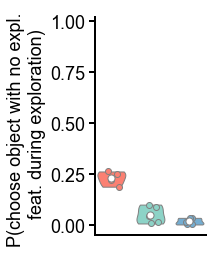

In [40]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(2,4), sharey=True)

vpWidth = 0.5

# Collect dat
D = np.zeros((numSubjects))
for i in range(numSubjects):
    D[i] = 1.0-analysis[i]['categoryAnalysis']['randomnessDurExp'] #[8]

# Plot
for i in np.unique(speciesList): # Species
    idx = np.where(np.array(speciesList) == i)[0]
    dat = D[idx]
    dat = np.delete(dat,np.nonzero(np.isnan(dat))[0], axis=0)
    
    # Violins
    vp = ax.violinplot(dat,[i*0.7],showextrema=False,widths=vpWidth)
    for pc in vp['bodies']:
        pc.set_facecolor(speciesColor[i])
        pc.set_edgecolor('gray')
        pc.set_alpha(1)

    # Points
    x = npr.rand(dat.shape[0]) * (vpWidth) * (0.3)
    pm = getPM(dat.shape[0])
    x = np.multiply(x,pm)+i*0.7#-0.1#i-0.1 #np.multiply(x,pm) + i

    ax.scatter(x,dat,color=speciesColor[i],edgecolors='gray')
    ax.scatter(i*0.7,np.mean(dat),color='white',s=50,edgecolors='gray')

# Prettify
ax.set_ylim([-0.05,1.02])
ax.set_xlim([-0.3,1.7])
ax.set_xticks([])

ax.set_yticks([0,0.25,0.5,0.75,1])

ax.set_ylabel('P(choose object with no expl. \n feat. during exploration)',fontsize=18)

ax.tick_params(axis='both',labelsize= 18,direction='out',width=2, length=6)
# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig('figures/fig4/randomChDurExp.eps', format='eps')